In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[2], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights
# from models import VAE_Model_ATLAS_beta as NNmodel

2025-07-21 14:06:53.820459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-21 14:06:55.262317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def Qmake_discriminator(input_dim, h_dim_1, h_dim_2):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = Dense(h_dim_1,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros())(inputs)
    x = Dense(h_dim_2,
              activation='relu',
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros())(x)
    x = Dense(1,
              activation='sigmoid',  # Output probability
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros())(x)
    discriminator = keras.Model(inputs, x, name='discriminator')
    return discriminator
def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
    jet_scale = 1
    tau_scale = 1
    muon_sacle = 1
    met_scale = 1

    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: jet_scale,
        3: jet_scale,
        6: jet_scale,
        9: jet_scale,
        12: jet_scale,
        15: jet_scale,
        18: tau_scale,
        21: tau_scale,
        24: tau_scale,
        27: tau_scale,
        30: muon_sacle,
        33: muon_sacle,
        36: muon_sacle,
        39: muon_sacle,
        42: met_scale
    }
    
    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)
    
    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor
    
#     # Hardcoded lists for eta and phi indices
#     eta_indices = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40]
#     phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 43]

#     batch_size = tf.shape(scaled_reconstruction)[0]
    
#     # Apply constraints to eta
#     for i in eta_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
#     # Apply constraints to phi
#     for i in phi_indices:
#         indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
#         updates = 3.14159265258979*(10/8) * tf.tanh(scaled_reconstruction[:, i] / (3.14159265258979*(10/8)))
#         scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)
    
    # Take the mean across all dimensions
    return tf.reduce_mean(mse)

class VAE_GAN_Model(keras.Model):
    def __init__(self, encoder, decoder, discriminator, steps_per_epoch=20,cycle_length=20, min_beta=0, max_beta=1,min_gamma=0, max_gamma=1, max_epochs = 100, **kwargs):
        super().__init__(**kwargs)
        self.max_epochs = max_epochs # Max number of epochs the model is going to be trained over

        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

        # per keras VAE example https://keras.io/examples/generative/vae/
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gamma_tracker = keras.metrics.Mean(name="gamma")


        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.beta = tf.Variable(min_beta, dtype=tf.float32)

        self.min_gamma = tf.cast(min_gamma, tf.float32)
        self.max_gamma = tf.cast(max_gamma, tf.float32)
        self.gamma = tf.Variable(min_gamma, dtype=tf.float32)

    def compile(self, optimizer, **kwargs):
        super(VAE_GAN_Model, self).compile(**kwargs)
        # Set the optimizer for the entire model (encoder + decoder + discriminator)
        self.optimizer = optimizer

        # Collect trainable variables from encoder, decoder, and discriminator
        trainable_variables = (
            self.encoder.trainable_weights + 
            self.decoder.trainable_weights + 
            self.discriminator.trainable_weights
        )
        # Build the optimizer with the full variable list
        self.optimizer.build(trainable_variables)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.discriminator_loss_tracker,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        # For first half (x < 0.5), scale 2x from 0 to 1
        # For second half (x >= 0.5), stay at 1
        scaled_x = tf.where(x < 0.5, 2.0 * x, 1.0)
        return self.min_beta + (self.max_beta - self.min_beta) * scaled_x
    
    # def cyclical_annealing_beta(self, epoch):
    #     # Get position within current cycle (0 to cycle_length)
    #     cycle_position = tf.math.mod(epoch, self.cycle_length)
        
    #     # For first half of cycle, increase linearly
    #     # For second half, stay at max
    #     half_cycle = self.cycle_length / 2
    #     scaled_x = tf.where(cycle_position <= half_cycle,
    #                     cycle_position / half_cycle,  # Linear increase in first half
    #                     1.0)                         # Stay at max for second half
        
    #     return self.min_beta + (self.max_beta - self.min_beta) * scaled_x


    # def get_gamma_schedule(self, epoch):
    #     # Convert to float32 for TF operations
    #     epoch = tf.cast(epoch, tf.float32)
        
    #     # Calculate annealing progress
    #     anneal_progress = (epoch - 50.0) / 50.0
    #     gamma_anneal = self.min_gamma + (self.max_gamma - self.min_gamma) * anneal_progress
        
    #     # Implement the conditions using tf.where
    #     gamma = tf.where(epoch < 50.0, 
    #                     0.0,  # if epoch < 50
    #                     tf.where(epoch >= 100.0,
    #                             self.max_gamma,  # if epoch >= 100
    #                             gamma_anneal))   # if 50 <= epoch < 100
        
    #     return gamma

    def get_gamma_schedule(self, epoch):
        """Simple linear schedule where gamma is min at the beginning and reaches 
        max at epoch 100"""
        # Convert to float32 for TF operations
        epoch = tf.cast(epoch, tf.float32)
        
        # Calculate annealing progress
        anneal_progress = (epoch - 0.0) / self.max_epochs
        gamma_anneal = self.min_gamma + (self.max_gamma - self.min_gamma) * anneal_progress
        # slope = (self.max_gamma -  self.min_gamma)/self.max_epochs

        return gamma_anneal


    def train_step(self, data):
        # Is this the beta tuning?
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        
        # Update beta
        self.beta.assign(self.cyclical_annealing_beta(epoch))
        self.gamma.assign(self.get_gamma_schedule(epoch))

        # ---------------------------
        # Train the Discriminator
        # ---------------------------
        with tf.GradientTape() as tape_disc:
            # Generate reconstructed data
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Get discriminator predictions
            real_output = self.discriminator(data)
            fake_output = self.discriminator(reconstruction * mask)
            
            # Labels for real and fake data
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)
            
            # Discriminator loss
            d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
            d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
            d_loss = d_loss_real + d_loss_fake
            d_loss = tf.reduce_mean(d_loss)
        
        grads_disc = tape_disc.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_weights))

        # ---------------------------
        # Train the VAE (Generator)
        # ---------------------------
        with tf.GradientTape() as tape:
            # Giving clean data here versus noisy in the atlas version
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # here we shove in our custom reconstructionn loss function
            # Ignore zero-padded entries. 
            mask = K.cast(K.not_equal(data, 0), K.floatx()) 
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*reconstruction, mask*data)
            reconstruction_loss *=(1-self.beta)

            # This is just standard Kullback-Leibler diversion loss. I think this can stay.
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta

            # Generator (VAE) wants to fool the discriminator
            fake_output = self.discriminator(mask*reconstruction)
            valid_labels = tf.ones_like(fake_output)  # Try to make discriminator think reconstructions are real
            g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
            g_loss_adv = tf.reduce_mean(g_loss_adv)

            # curr_training_gamma = self.gamma * (epoch / 50)  # TODO 50 is arbitrary based on max_epochs # Not sure what this is doing.
            
            total_loss = reconstruction_loss + kl_loss + g_loss_adv * self.gamma

        # ----- Review for differences
        # grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # self.total_loss_tracker.update_state(total_loss)
        # self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        # self.kl_loss_tracker.update_state(kl_loss)

        grads_vae = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_vae, self.encoder.trainable_weights + self.decoder.trainable_weights)) # This line is different
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.discriminator_loss_tracker.update_state(g_loss_adv)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "disc_loss": self.discriminator_loss_tracker.result(),
            "beta": self.beta,
            "raw_loss": self.reconstruction_loss_tracker.result() + self.kl_loss_tracker.result(),
            "w_kl_loss": self.kl_loss_tracker.result() * self.beta,
            "w_disc_loss": self.discriminator_loss_tracker.result() * self.gamma,
            "gamma": self.gamma,
        }
    
    # Since we overrode train_step we need test_step
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask*data, mask*reconstruction)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        # Discriminator loss (only for monitoring)
        # pass both data and reconstruction through D to get generator adversarial loss
        real_output = self.discriminator(data)
        fake_output = self.discriminator(mask*reconstruction)
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)
        d_loss_real = keras.losses.binary_crossentropy(real_labels, real_output)
        d_loss_fake = keras.losses.binary_crossentropy(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake
        d_loss = tf.reduce_mean(d_loss)
        
        # Generator adversarial loss
        valid_labels = tf.ones_like(fake_output)
        g_loss_adv = keras.losses.binary_crossentropy(valid_labels, fake_output)
        g_loss_adv = tf.reduce_mean(g_loss_adv)
        total_loss = reconstruction_loss + kl_loss * self.beta + g_loss_adv * self.gamma
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "raw_loss": reconstruction_loss + kl_loss,
            "disc_loss": g_loss_adv,
            "w_kl_loss": kl_loss * self.beta,
            "w_disc_loss": g_loss_adv * self.gamma,
            "gamma": self.gamma
        }


    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }


In [11]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    # Comparing this to eq 2 in arXiv: 2108.03986 z_log_var = log(sigma**2)
    return kl_loss


def AD_score_CKL(z_mean, _): # z_log_var not used
    CKL = np.mean(z_mean**2)
    return CKL 

def AD_score_Rz(z_mean, z_log_var):
    return z_mean**2/np.exp(z_log_var)

def calc_anomaly_scores(data, encoder: keras.Model, AD_metric, debug = True):
    """
    Parameters:
    -----------
    debug: Optional bool to skip latent space vectors that produce infinities.
    Currently set to true as it seems only 2 specific cases are affected
    """
    dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
    # Kenny only uses the first list so we'll follow that convention.
    # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
    scores = np.zeros(len(data))
    bad_model = False
    for i in range(len(scores)):
        z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
        score = AD_metric(z_mean, z_log_var)
        if debug and (score == np.inf or score == np.nan):
            print("Unstable model: inf encountered. Rejecting Model"
                  + f"z_mean: {z_mean}\n"
                  + f"z_log_var: {z_log_var}")
            
            bad_model = True
            break
        scores[i] = score

    return (scores, bad_model)

In [4]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:           # Shapes:
    X_train = hf['X_train'][:]                  # (3200000, 57)
    X_test  = hf['X_test'][:]                   # (800000,  57)
    Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data? 
    hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57)
    hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57)
    leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57)
    print("Data loaded from preprocessed_SNL_data.h5")

    # Change to what the paper is doing. Only standardized p_t

Data loaded from preprocessed_SNL_data.h5


##### Calculate Anomaly scores

In [5]:
def get_truth_and_scores(encoder, AD_metric, debug=True):
    bg_score, bad_model = calc_anomaly_scores(X_test, encoder, AD_metric)
    scores = []
    truths = []
    zeros = np.zeros(len(X_test))
    signal_data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data]

    # Generate Truth and score lists ready for ROC curve calculation
    if not(bad_model):
        for dat in signal_data:
            truths.append(np.concatenate((zeros, np.ones(len(dat)))))

            s, _ = calc_anomaly_scores(dat, encoder, AD_metric, debug=debug)
            scores.append(np.concatenate((bg_score,s) ))

    return (truths, scores, bad_model)

In [6]:

def plot_rocs(truths, scores, fig_title):
    target_fpr = 1e-5
    tpr_at_target = []
    signal_names_tex = [ # latex version
                    "Leptoquark"
                    , "$A\\rightarrow 4\ell$"
                    , "$h^{\pm}\\rightarrow\\tau \\nu$"
                    , "$h^0\\rightarrow\\tau\\tau$"
                    ]
    signal_names_hum = [ # human readable
                    "Leptoquark"
                    ,"A to 4L"
                    , "h to Tau Nu"
                    , "h to Tau Tau"
                    ]
    fig, ax = plt.subplots()

    thresholds_at_target = []
    for truth, score, l in zip(truths, scores, signal_names_tex):
        fpr, tpr, thresholds = roc_curve(truth, score)
        auc = sk.roc_auc_score(truth, score)
        ax.plot(fpr, tpr, label=l + f": {str(round(auc, 3))}") # plot roc curve


        # Find tpr at fpr target
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_target.append(tpr[idx])
        thresholds_at_target.append(thresholds[idx])

    ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--")
    ax.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")

    # Plot teaks
    ax.loglog()
    ax.legend()
    ax.grid()
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.set_title(fig_title) 
    plt.show()

    for i in range(len(signal_names_hum)):
        print(signal_names_hum[i] + " TPR @ FPR 10e-5 (%): " + f"{tpr_at_target[i]*100:.2f}\n" + f"Target Threshold {thresholds_at_target[i]}")

    return fig



In [7]:
'test' + ''

'test'

21603/21603 [==============================] - 14s 639us/step


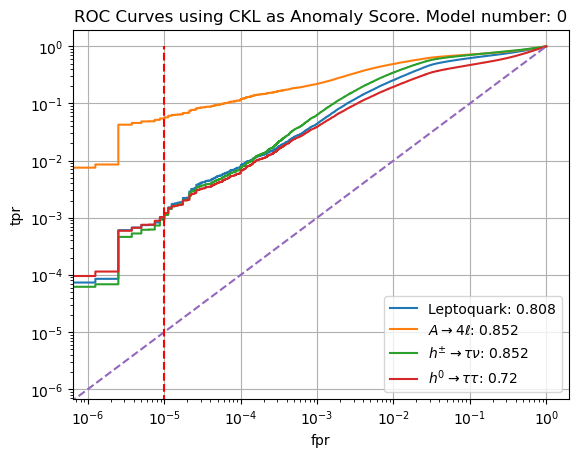

Leptoquark TPR @ FPR 10e-5 (%): 0.10
Target Threshold 1276.08745642961
A to 4L TPR @ FPR 10e-5 (%): 5.46
Target Threshold 1276.08745642961
h to Tau Nu TPR @ FPR 10e-5 (%): 0.09
Target Threshold 1276.08745642961
h to Tau Tau TPR @ FPR 10e-5 (%): 0.10
Target Threshold 1276.08745642961
21603/21603 [==============================] - 13s 610us/step


ValueError: Input contains NaN.

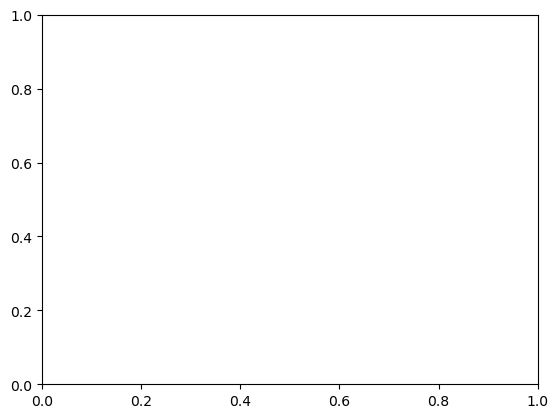

In [9]:
from pathlib import Path


INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_TRAIN = 10 # number of trained models

SAVE_PATH = home_path+f"/GAN_trainings/attempt6/" 
bad_models = []
SAVE_FIG = True
FILE_NAMES = ""
FIG_SAVE_PATH = SAVE_PATH + "plots/"
AD_metric = AD_score_CKL 


for i in range(NUM_TRAIN):
    new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
    new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
    new_disc = Qmake_discriminator(INPUT_SZ, 8, 2)
    new_VAE = VAE_GAN_Model(new_enc, new_dec, new_disc)
    save_path = SAVE_PATH + f"n_{i}/"

    new_VAE.load_weights(save_path)

    just_enc = new_VAE.get_layer("encoder") # We only need encoder output
    t, s, bad_model = get_truth_and_scores(just_enc, AD_metric)
    if bad_model:
        print(f"Unstable mode. Inf encountered. Model number {i} ")
        bad_models.append(i)
    else:
        f = plot_rocs(t, s, "ROC Curves using CKL as Anomaly Score. Model number: " + str(i))

        if SAVE_FIG:
            Path(FIG_SAVE_PATH+FILE_NAMES).mkdir(parents=True, exist_ok=True)
            f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")


In [10]:
bad_models

[]

After inspecting the graphs a few notable models remain

In [ ]:
import pickle as pkl

SAVE_FIG = False
noteable_models_iter = [
                        # 0,
                        # 9,
                        # 14,
                        16 # best when considering DKL
                        # 17
                        ] # mins 88, 90, 89, 79 for AUC. 
# # 16 did the best AUC and I think also has higher TPR @ target FPR
AD_metric = AD_score_CKL

# for i in noteable_models_iter:

#     # Reload the Encoder ------
#     # for i in range(NUM_TRAIN):
#     new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_VAE = NNmodel(new_enc, new_dec)
#     save_path = SAVE_PATH + f"n_{i}/"

#     new_VAE.load_weights(save_path)

#     just_enc = new_VAE.get_layer("encoder") # We only need encoder output
#     # ------

#     # Plot ROC curves and optionally save -----
#     t, s, bad_model = get_truth_and_scores(just_enc, AD_metric)

#     if bad_model:
#         print(f"Unstable mode. Inf encountered. Model number {i} ")
#         bad_models.append(i)
#         continue


#     f = plot_rocs(t, s, "ROC Curves using $D_{KL}$ as Anomaly Score. Model number: " + str(i))

#     if SAVE_FIG:
#         f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")
#     # ------

#     # Reload history and plot loss curves ------
#     save_path = SAVE_PATH + f"n_{i}/"
#     with open(save_path + 'training_history.pkl', 'rb') as f:
#         history = pkl.load(f)
#     # Extract the loss values
#     total_loss = history['loss']
#     reco_loss = history['reconstruction_loss']
#     kl_loss = history['kl_loss']
#     val_total_loss = history['val_loss']
#     val_reco_loss = history['val_reconstruction_loss']
#     val_kl_loss = history['val_kl_loss']

#     # Create a new figure
#     plt.figure(figsize=(12, 8))

#     # Plot training losses
#     plt.plot(total_loss, label='Total Loss', color='blue')
#     plt.plot(reco_loss, label='Reconstruction Loss', color='green')
#     plt.plot(kl_loss, label='KL Loss', color='red')
#     plt.plot(history['beta'],label="beta")

#     # Plot validation losses
#     plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
#     plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
#     plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

#     # Customize the plot
#     plt.title(f'Training and Validation Losses Run: {i}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.yscale("log")
#     plt.legend()
#     plt.grid(True)

#     # Show the plot
#     plt.show()
#     # -----

#     # Plot Anomaly score distribution -----


Anamoly Score Distribution

In [ ]:
def calc_anomaly_dist(data, encoder: keras.Model, AD_metric):
    """
    Parameters:
    -----------
    debug: Optional bool to skip latent space vectors that produce infinities.
    Currently set to true as it seems only 2 specific cases are affected
    """
    dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
    # Kenny only uses the first list so we'll follow that convention.
    # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
    scores = np.zeros(len(data))
    for i in range(len(scores)):
        z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
        scores[i] = AD_metric(z_mean, z_log_var)
    
    return scores

In [ ]:
new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_disc = Qmake_discriminator(INPUT_SZ, H1_SZ, H2_SZ)
new_VAE = VAE_GAN_Model(new_enc, new_dec, new_disc)
save_path = SAVE_PATH + f"n_{0}/" # 16 is the interesting one DKL, 8 is the one for CKL

new_VAE.load_weights(save_path)

just_enc = new_VAE.get_layer("encoder") # We only need encoder output


In [ ]:

data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data
               , X_train
               , X_test
               ]
data_names_tex = [ # latex version
                "Leptoquark"
                , "$A\\rightarrow 4\ell$"
                , "$h^{\pm}\\rightarrow\\tau \\nu$"
                , "$h^0\\rightarrow\\tau\\tau$"
                , "Training Set (BG)" # Background
                , "Test Set (BG)" # Background
                ]

anomaly_scores = []
for data in data:
    s = calc_anomaly_dist(data, just_enc, AD_score_CKL)
    anomaly_scores.append(s)

for i in range(len(data_names_tex)):
    dat = anomaly_scores[i]
    bin_n = int(len(dat))
    # print(bin_n)
    plt.hist(dat
             , bins = int(bin_n/400)
             , label=data_names_tex[i] # + " " + str(bin_n)
             , histtype = "step"
            #  , density=True
             )

plt.legend(loc="upper right")
# plt.loglog()
plt.semilogy()
# plt.semilogx()
plt.xlabel("Clipped KL")
plt.ylabel("Count")
plt.grid()
plt.ylim((0.8, 1000))
plt.xlim((0, 1000))